In [7]:
import re
from agent.utils.tools import WikidataTool, GoogleSearchTool, calculator, python_interpreter, WikipediaTool, GoogleKnowledgeGraphTool
from agent.utils.loader import load_processed_data
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv, find_dotenv
import os

from agent.utils.tools import BingSearchTool

# Optional, add tracing in LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "self-correct"
os.environ["LANGCHAIN_ENDPOINT"]="https://api.smith.langchain.com"
_ = load_dotenv(find_dotenv())

In [8]:
dataset_name = 'hotpot_qa'
mode = "self-improve"
model = "gpt-4o-mini-2024-07-18"
num_samples = 100
top_p = 0.95
temperature = 0
seed = 42
batch_size = 100
if dataset_name == "toxicity":
	temperature = 0.9
	n = 25
else:
	temperature = 0
	n = 1
processed_data_path = f"../../data/processed_data/{dataset_name}.jsonl"
if "gpt-4o-mini" in model:
	save_results_path = f"../../output/inference/gpt-4o-mini/{dataset_name}/{mode}/num_samples_{num_samples}_top_p_{top_p}_temperature_{temperature}_seed_{seed}.jsonl"
else:
	save_results_path = f"../../output/inference/{model}/{dataset_name}/{mode}/num_samples_{num_samples}_top_p_{top_p}_temperature_{temperature}_seed_{seed}.jsonl"
dataset = load_processed_data(dataset_name=dataset_name, file_path=processed_data_path)
if num_samples > 0:
	dataset = dataset.select(range(num_samples))
print(dataset[0])

wikidata_tool = WikidataTool()
google_search_tool = GoogleSearchTool()
bing_search_tool = BingSearchTool()
calculator = calculator
python_interpreter = python_interpreter
wikipedia_tool = WikipediaTool()
google_knowledge_graph_tool = GoogleKnowledgeGraphTool(api_key=os.environ.get("GOOGLE_API_KEY"))
tool_set = {"wiki_data": wikidata_tool, "google_search": google_search_tool, "bing_search": bing_search_tool, "calculator": calculator, "python_interpreter": python_interpreter, "wikipedia": wikipedia_tool, "google_knowledge_graph": google_knowledge_graph_tool}
tool_description = "\n".join([f"[{tool_name}] - {tool.description}" for tool_name, tool in tool_set.items()])

{'context': '', 'question': 'Were Scott Derrickson and Ed Wood of the same nationality?', 'answer': ['yes']}


In [9]:
print(tool_set["google_search"].run("actress who portrayed Corliss Archer in the film \"Kiss and Tell\""))

{'title': 'Kiss and Tell (1945 film) - Wikipedia', 'snippet': 'Kiss and Tell is a 1945 American comedy film starring then 17-year-old Shirley Temple as Corliss Archer. In the film, two teenage girls cause their\xa0...'}


# Define State

In [10]:
import asyncio
from tqdm.asyncio import tqdm_asyncio
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.prompts import ChatPromptTemplate
import operator


MAX_ITERATIONS = 4

class Tool(TypedDict):
	tool_name: str
	input: str

class Guidance(TypedDict):
	guidance: str
	tool_list: List[Tool]

class Step(TypedDict):
	step: str
	error_prone_points: str
	cot_message: str

class State(TypedDict):
	iteration: int
	question: str
	step: List[Step]
	tool_execution_list: Annotated[List[Tuple[str, str, str]], operator.add]
	final_answer: str
	

In [11]:
plan_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """Given a question, come up with an overall plan of the problem solving process. The plan you come up with should stay in line with the Chain of Thought. Your response should follow the format "step: <description of the step>".

For example: 
step: <description of the step> 
step: <description of the step> 
...(repeat if necessary)
""",
        ),
        ("placeholder", "{messages}"),
    ]
)

plan = plan_prompt | ChatOpenAI(
    model=model, temperature=0, top_p=0.95, n=1, base_url="https://api.chsdw.top/v1"
)

	
async def plan_step(state: State):
	assert state["question"] is not None
	plan_message = state["question"]
	try:
		plan_response = await plan.ainvoke({"messages": [plan_message]})
	except Exception as e:
		print(e)
		return {"cot_messages": []}
	
	step_list = re.findall(r'step: (.*?)\n', plan_response.content)
	step_list = [{"step": step, "error_prone_points": [], "cot_message": None} for step in step_list]
	return {
		"step": step_list,
	}

In [12]:
error_prone_identification_prompt = ChatPromptTemplate.from_messages(
	[
		(
			"system",
			"""Based on the overall plan, identify all the error prone points in the problem solving process of each step. Remember that there may be multiple error-prone areas in each step, and you should list them all.

Your response should follow the format:
step: <description of the step>
point: <reason>

step: <description of the step>
point: <reason>

..."""
		),
        ("placeholder", "{messages}"),
	]
)

error_prone_identification = error_prone_identification_prompt | ChatOpenAI(
    model="gpt-4o-mini-2024-07-18", temperature=0, top_p=0.95, n=1, base_url="https://api.chsdw.top/v1"
)

async def error_prone_identification_step(state: State):
	assert state["step"] is not None
	step_list = "\n".join([f"step: {step["step"]}" for step in state["step"]])
	try:
		error_prone_identification_response = await error_prone_identification.ainvoke({"messages": [step_list]})
	except Exception as e:
		print(e)
		return {"cot_message": []}
	error_prone_points_list = error_prone_identification_response.content.split("step:")[1:]
	error_prone_points_list	= [re.findall(r'point: (.*?)\n', error_prone_point) for error_prone_point in error_prone_points_list]
	step_list = [
		{**step, "error_prone_points": error_prone_points}  # 新字典，包含更新
		for step, error_prone_points in zip(state["step"], error_prone_points_list)
	]
	return {
		"step": step_list
	}

In [13]:
guide_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            f"""Regarding current step and the error-prone points, choose the appropriate tools to help you complete current step. You should always use error-prone points as your guiding principles to guide subsequent behavior. Before providing the selected tools and corresponding inputs, you should fully understand the functions of each tool and their specific requirements for the input content. The tool name must accurately match the existing tool (including characters such as uppercase and lowercase, spaces, etc.). Remember that there may be multiple tools that meet the requirements, and there are also some tools that are not suitable for the current step. You need to truly understand the function of each tool and select the one that fits the current step. Avoid selecting tools that are obviously unsuitable.

You have the following tool set: 
{tool_description}
Tool name should be enclosed in angle brackets. Tool input should be surrounded by square brackets. Your response should follow the following format:

tool: <tool_name>[input]
...(repeat if necessary)
""",
        ),
        ("placeholder", "{messages}"),
    ]
)

guide = guide_prompt | ChatOpenAI(
    model=model, temperature=0, top_p=0.95, n=1, base_url="https://api.chsdw.top/v1"
)

async def tool_step(state: State):
	step_list = state["step"]
	first_none_index = next((i for i, step in enumerate(step_list) if step["cot_message"] is None), None)
	past_steps = "\n".join([f"step: {step["step"]}\nresult: {step["cot_message"]}" for step in step_list[:first_none_index]])
	try:
		selected_tools = await guide.ainvoke({"messages": [f"{past_steps}\ncurrent step: " + step_list[first_none_index]["step"] + "\npoint: " + "\npoint: ".join(step_list[first_none_index]["error_prone_points"])]})
		print(selected_tools.content)
	except Exception as e:
		print(e)
		
	tool_execution_list = re.findall(r'tool:\s*<(\w+)>\[(.*?)\]', selected_tools.content)
	async def tool_invoke(tool_name: str, input: str) -> tuple:
		try:
			result = tool_set[tool_name].run(input)
		except Exception as e:
			return tool_name, input, str(e)
		return tool_name, input, result
	
	tool_execution_list = await asyncio.gather(*(tool_invoke(tool_name, input) for tool_name, input in tool_execution_list))
	step_list[first_none_index].update({"tool_results": tool_execution_list})
	return {"step": step_list}

In [14]:
cot_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """Based on the error prone points and tool result, provide your answer to the current step. Remember that all the tool result are reliable. Your answer should be as concise as possible, and your response should not contain any additional thinking process.
""",
        ),
        ("placeholder", "{messages}"),
    ]
)

cot_revise = cot_prompt | ChatOpenAI(
	model=model, temperature=0, top_p=0.95, n=1, base_url="https://api.chsdw.top/v1"
)

async def cot_step(state: State):
	step_list = state["step"]
	first_none_index = next((i for i, step in enumerate(step_list) if step["cot_message"] is None), None)
	step_text = f"step: {step_list[first_none_index]['step']}\n"
	error_prone_points = "\n".join([f"point: {point}" for point in step_list[first_none_index]["error_prone_points"]])
	tool_execution_list = "\n\n\n".join([f"##tool: {tool_name}[{input}]\nresult:{result}" for tool_name, input, result in step_list[first_none_index]["tool_results"]])
	message = f"{step_text}{error_prone_points}\n\n{tool_execution_list}"
	try:
		cot_response = await cot_revise.ainvoke({"messages": [message]})
	except Exception as e:
		print(e)
	
	step_list[first_none_index].update({"cot_message": cot_response.content})
	return {"step": step_list}

In [15]:
print(tool_description)

[wiki_data] - A wrapper around Wikidata. Useful for when you need to answer general questions about people, places, companies, facts, historical events, or other subjects. Input should be the exact name of the item you want information about or a Wikidata QID.
[google_search] - A search engine. useful for when you need to answer questions about current events. Input should be a search query. 
[bing_search] - A search engine. useful for when you need to answer questions about current events. Input should be a search query. 
[calculator] - Useful when you need to calculate the value of a mathematical expression, including basic arithmetic operations. Use this tool for math operations. Input should strictly follow the numuxpr syntax.
[python_interpreter] - Useful when you need to execute a code and get the value of the variables. Use this tool for code execution.This tool will return the code execution result and final value of the variable you want to get.
[wikipedia] - A wrapper around 

In [16]:
async def should_final_answer(state: State):
	if state["step"][-1]["cot_message"] is not None:
		return "get_final_answer"
	else:
		return "tool"

final_answer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """Based on the following question and steps, answer the question. Remember your answer should be as concise as possible, and your response should not contain any additional thinking process.
""",
        ),
        ("placeholder", "{messages}"),
    ]
)

get_final_answer = final_answer_prompt | ChatOpenAI(
	model=model, temperature=0, top_p=0.95, n=1, base_url="https://api.chsdw.top/v1"
)

async def final_answer_step(state: State):
	question = state["question"]
	steps_text = "\n\n".join([f"step: {step['step']}\nresult: {step['cot_message']}" for step in state["step"]])
	try:
		final_answer = await get_final_answer.ainvoke({"messages": [f"{question}\n\n{steps_text}\n\n\n{question}"]})
	except Exception as e:
		print(e)
		return {"final_answer": "None"}
	
	return {"final_answer": final_answer.content}

In [17]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(State)

# Add the plan node
workflow.add_node("plan", plan_step)

# Add the error identification node
workflow.add_node("error_identification", error_prone_identification_step)

# Add a tool execution node
workflow.add_node("tool", tool_step)

# Add a revise node
workflow.add_node("cot", cot_step)

workflow.add_node("get_final_answer", final_answer_step)

workflow.add_edge(START, "plan")

# From plan we go to error identification
workflow.add_edge("plan", "error_identification")

workflow.add_edge("error_identification", "tool")

workflow.add_edge("tool", "cot")

workflow.add_conditional_edges(
	"cot",
	should_final_answer,
	["get_final_answer", "tool"],
)

workflow.add_edge("get_final_answer", END)

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

In [18]:
result = await app.ainvoke({"question": dataset[1]["question"], "final_answer": None})
    # print(s)
    # print("---")

tool: <google_search>[Kiss and Tell film Corliss Archer actress]
tool: <wiki_data>[Shirley Temple]  
tool: <google_search>[Shirley Temple government positions]  
tool: <bing_search>[Shirley Temple biography and career]  
tool: <google_search>[Shirley Temple government positions]  
tool: <wikipedia>[Shirley Temple]  
tool: <wiki_data>[Shirley Temple]  
tool: <google_knowledge_graph>[Shirley Temple]  


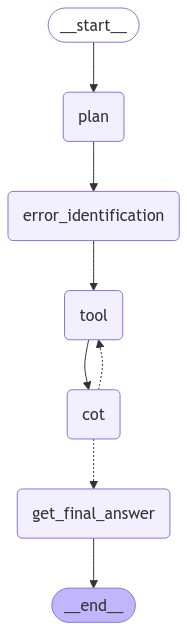

In [19]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [20]:
from tqdm.asyncio import tqdm, tqdm_asyncio
import nest_asyncio
import json

nest_asyncio.apply()
results = []
async def self_improve_inference() -> None:

	if os.path.exists(save_results_path):
	    with open(save_results_path, 'r') as file:
	        for line in file:
	            results.append(json.loads(line))
	else:
		folder_path = os.path.dirname(save_results_path)
		os.makedirs(folder_path, exist_ok=True)
	
	for idx in tqdm(range(len(results), 100, batch_size)):
		batch = dataset.select(range(idx, min(idx+batch_size, dataset.num_rows)))
		for i in tqdm(range(batch_size)):
			results.append({**(await app.ainvoke({**batch[i], "final_answer": None})), **batch[i]})
		with open(save_results_path, 'w') as file:
			for result in results:
				file.write(json.dumps(result) + "\n")


In [ ]:
await self_improve_inference()

In [27]:
with open(save_results_path, 'w') as file:
	for result in results:
		file.write(json.dumps({"question":result["question"], "answer":result["answer"], "prediction":result["final_answer"]}) + "\n")
